## wantのinstall
pdfをjupyter上で表示するためにwandをinstallしておく。
```sh
$ pip install wand
```

## Imagemagickのpolicy fileの変更
pdfをimageに変換するために
Imagemagickのpolicy fileを変える。
```sh
$ sudo vi /etc/ImageMagick-6/policy.xml
```
rights部分をread|writeに変える。
```
  <policy domain="coder" rights="read|write" pattern="PS" />
  <policy domain="coder" rights="read|write" pattern="PS2" />
  <policy domain="coder" rights="read|write" pattern="PS3" />
  <policy domain="coder" rights="read|write" pattern="EPS" />
  <policy domain="coder" rights="read|write" pattern="PDF" />
  <policy domain="coder" rights="read|write" pattern="XPS" />
```

## restart kernel
jupyter kernelをrestartする。


Python内では必ずprofileの指定を行う。

In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile() # profile名を指定しない場合はdefaultになる。

# aiida.load_profile("20210628") profile名を指定してもよい。

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

@calcfunctionを用いてAiiDAが理解できるようにnodeを繋げる。

制限
1. @calcuntionの入出力は AiiDAの型でなければいけない。

機能
1. aiida nodeに自動的にstore()される。
1. nodeの値はnode.valueとして得られる。

In [2]:
import numpy as np
from aiida.engine import calcfunction,workfunction
from aiida.orm import Float

@calcfunction
def energy(x):
    return Float(x**2)

@calcfunction
def force(x):
    return Float(-2*x)

@calcfunction
def new_x(x,f,a):
    # implicit に型を定義している
    new_x = x + a * f   
    return new_x

In [3]:
import aiida
aiida.orm

<module 'aiida.orm' from '/home/kino/miniconda3/envs/aiida/lib/python3.10/site-packages/aiida/orm/__init__.py'>

Success: Output written to `11356.dot.pdf`


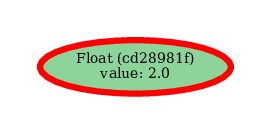

In [4]:
x0 = Float(2)
x0.store()
pk = x0.pk
!verdi node graph generate $pk

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

In [5]:
x0.uuid, x0.pk

('d09e3928-6f1c-486b-8279-f1e73a6725e4', 8998)

@calcfunctionは
* 入力がAiiDAの型でなくても動作する。
* 出力は変換できればAiiDAの型を作る。

'x=3'は'Float(-2\*x)'に変換できるので動作する。
'x=np.array([1,2,3])''は'Float(-2\*x)'に変換できないので動作しない。


Success: Output written to `8998.dot.pdf`


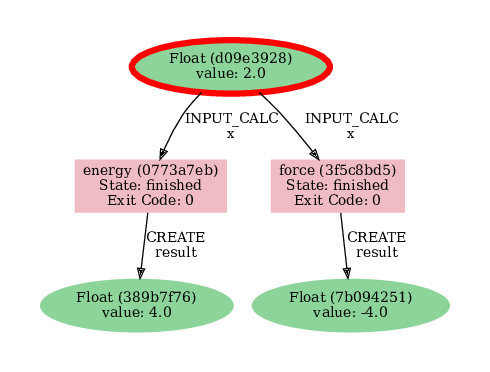

In [6]:
a = Float(0.4)
fth = Float(1e-5)
ene = energy(x0)
f = force(x0)
pk = x0.pk
import subprocess
# cmd = "verdi node graph generate {}".format(pk)
# subprocess.call(cmd,shell=True)
!verdi node graph generate $pk

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

@workfunctionでは

1. 入出力はAiiDAの型である。
2. 出力は内部でstore()されてないといけない。例えば、@calcfunctionの出力は自動的にstore()される。

In [11]:
# 例
@workfunction
def force(x):
    result =  Float(-2*x)
    result.store() # 手動でstore()するとエラーが出ない。
    return result
force(Float(1))

<Float: uuid: e226e82e-75e2-4794-a9e4-b3642f35e237 (pk: 11373) value: -2.0>

下は@workfunctionを定義しなくても動く。動作がどう違うか各自試してほしい。
@workfunctionをつけておくのが正式なやり方なのでつけておく。

@workfunctionをつけると、内部でデータが入力からまで繋がることを確認してくれる、繋がっていない場合はエラーになるハズ。

In [7]:
@workfunction
def stable_x(x,a,fth):
    print_type="value"
    f = force(x)
    x = x0
    i = 0
    print(f,fth)
    while np.abs(f.value) > fth.value:
        y = energy(x) # @calcfunction
        if print_type=="node":
            print(i,"X",x,"force",f,"energy",y)   
        else:
            print(i,"X",x.value,"force",f.value,"energy",y.value)   
        x = new_x(x,f,a) # @calcfunction
        f = force(x)        
        
        i+=1

    if print_type=="node":
        print("stable X",x,"force",f,"energy",y)   
    else:
        print("stable X",x.value,"force",f.value,"energy",y.value)   
    return x

x0 = Float(2)
a = Float(0.4)
fth = Float(1e-5)

stable_x =  stable_x(x0,a,fth) # @calcfunction
stable_x

uuid: 053cb48a-3918-4649-b6d5-0c57f6f7c938 (pk: 9008) value: -4.0 uuid: 253b56bf-666f-4695-acd8-ddd2f6e33a04 (pk: 9005) value: 1e-05
0 X 2.0 force -4.0 energy 4.0
1 X 0.4 force -0.8 energy 0.16
2 X 0.08 force -0.16 energy 0.0064
3 X 0.016 force -0.032 energy 0.000256
4 X 0.0032 force -0.0064 energy 1.024e-05
5 X 0.00064 force -0.00128 energy 4.096e-07
6 X 0.000128 force -0.000256 energy 1.6384e-08
7 X 2.56e-05 force -5.12e-05 energy 6.5536e-10
8 X 5.12e-06 force -1.024e-05 energy 2.62144e-11
stable X 1.024e-06 force -2.048e-06 energy 2.62144e-11


<Float: uuid: fdc96190-cd79-42df-9735-fdc89683e207 (pk: 9060) value: 1.024e-06>

@calcfunctionでAiiDAの型の変数（上の場合はFloat)をつなぐことで自動的にAiiDA内部でノードがつながるようになる。

実績グラフの表示

In [8]:
import subprocess
pk = stable_x.pk
cmd = "verdi node graph generate {}".format(pk)

Success: Output written to `9060.dot.pdf`


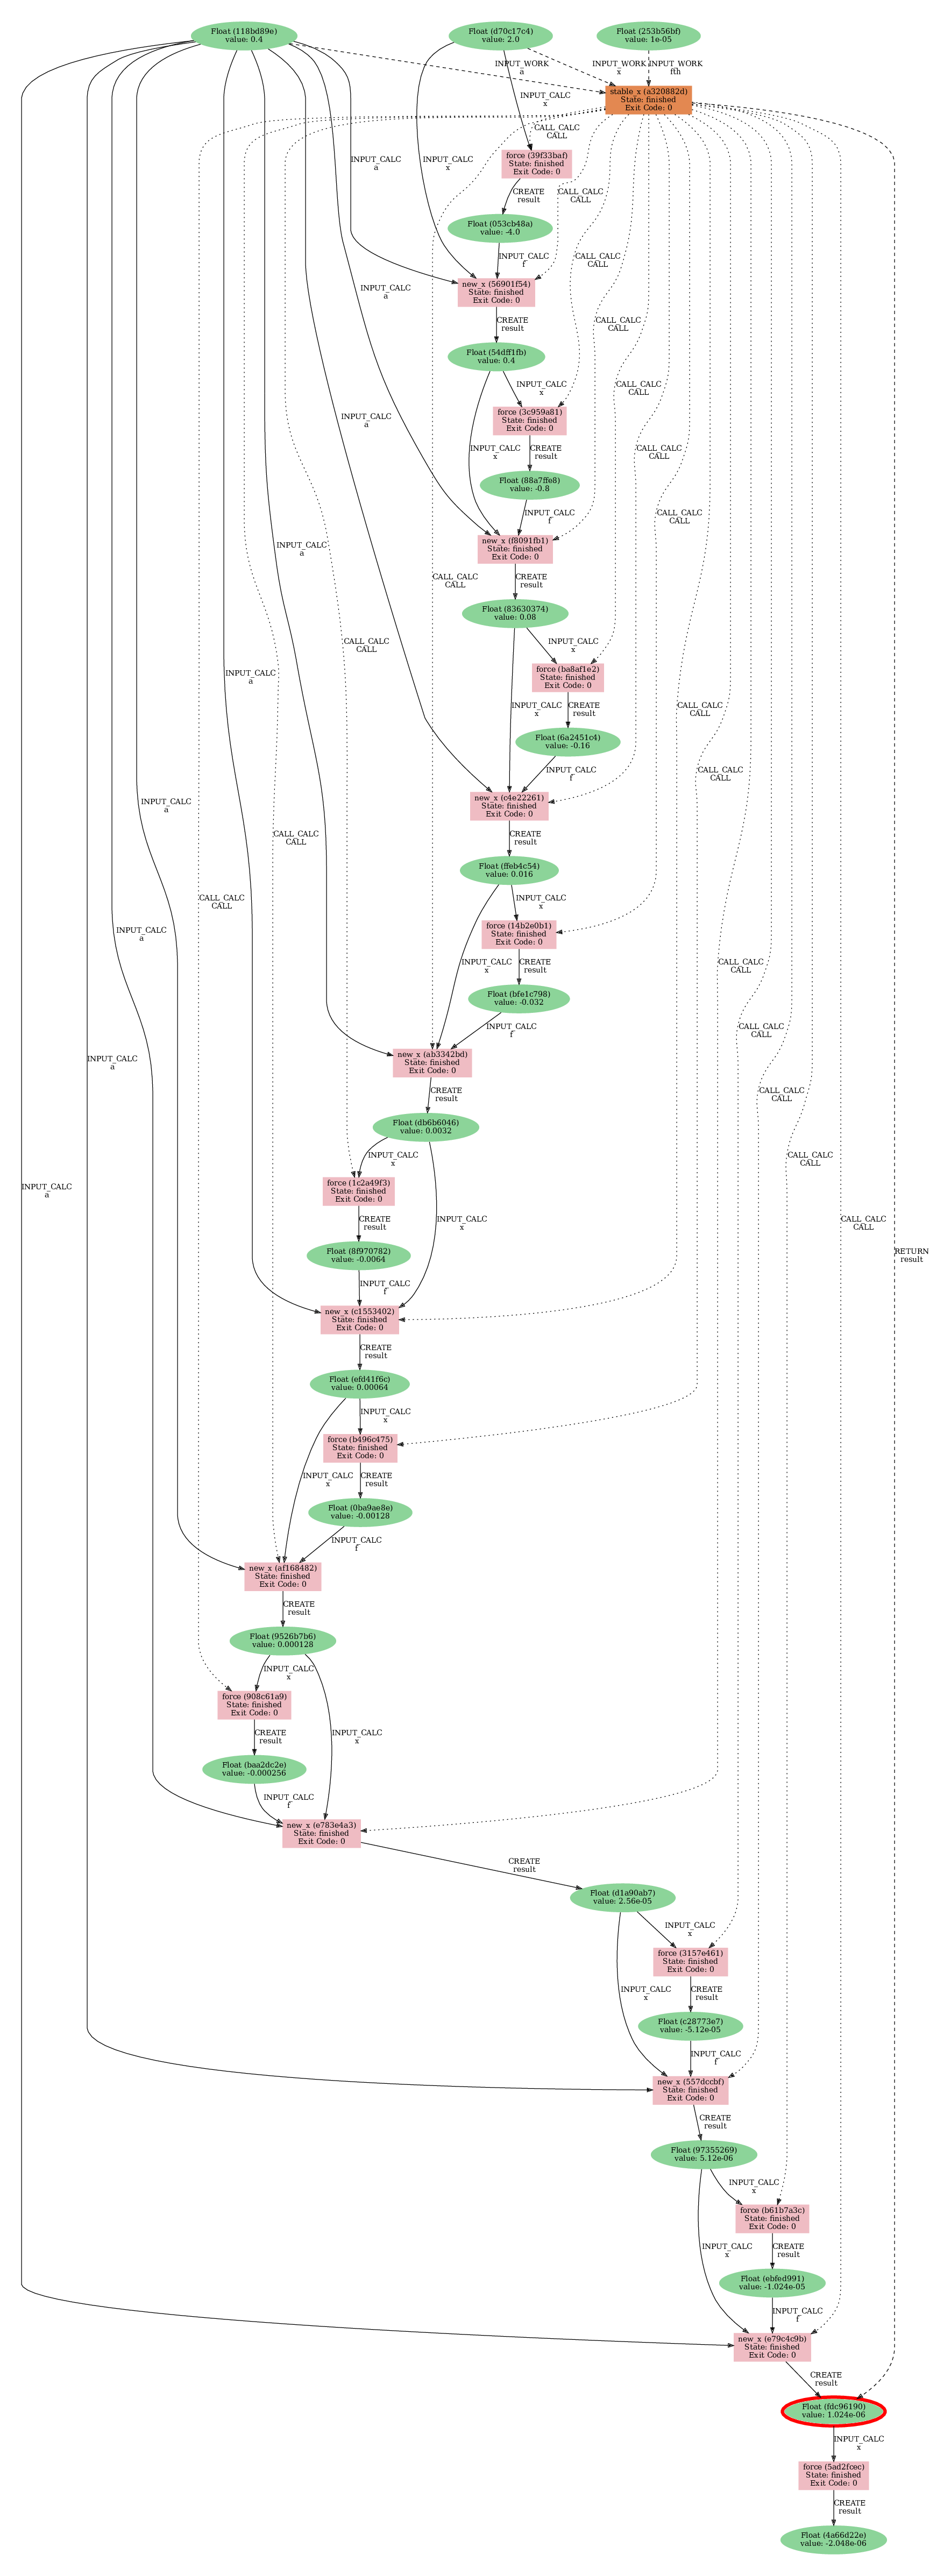

In [9]:
subprocess.call(cmd,shell=True)
# !verdi node graph generate $pk と同じ。

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

# Profile directoryについての補足

/home/max/.aiida/repository/20210719/の下にdirectoryができている。
```sh
ls -F /home/max/.aiida/repository/20210719
```
```console
repository/  sandbox/
```

AiiDA nodeの実体は以下にある。
```sh
ls -F /home/max/.aiida/repository/20210719/repository/node
```
```console
01/  1d/  2b/  37/  4e/  58/  77/  88/  92/  a9/  b5/  d3/  db/  ea/  fb/
0f/  28/  2d/  3e/  52/  67/  7a/  8d/  96/  ac/  b9/  d4/  e0/  f3/  fc/
18/  29/  2e/  42/  53/  6c/  7e/  8f/  9b/  af/  bb/  d8/  e3/  f4/
19/  2a/  34/  45/  54/  73/  86/  90/  9e/  b0/  bf/  da/  e5/  f8/
```
例えば
'01/9e/7b1a-4e66-4323-8e2d-358af1b30427'
directoryがuuid '019e7b1a-4e66-4323-8e2d-358af1b30427'に対応する。
今は、それぞれのdirectoryにはpath/しかない。
これらは外部machineとやり取りする場合にファイルが置かれる。

database上でnodeが作られstore()されると必ず.aiida/repository/{profile名}/repository/nodeにもdirectoryができる。これはaiida.ormクラスの機能でAiiDAの基本的な仕様である。
